C:\Users\Aniruddha\AppData\Local\Temp\ipykernel_4240\56048790.py:163: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat,p,lag,crit = kpss(s, regression=reg, nlags="auto")
C:\Users\Aniruddha\AppData\Local\Temp\ipykernel_4240\56048790.py:163: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat,p,lag,crit = kpss(s, regression=reg, nlags="auto")
C:\Users\Aniruddha\AppData\Local\Temp\ipykernel_4240\56048790.py:163: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat,p,lag,crit = kpss(s, regression=reg, nlags="auto")
C:\Users\Aniruddha\AppData\Local\Temp\ipykernel_4240\56048790.py:163: InterpolationWarning: The test statistic is o

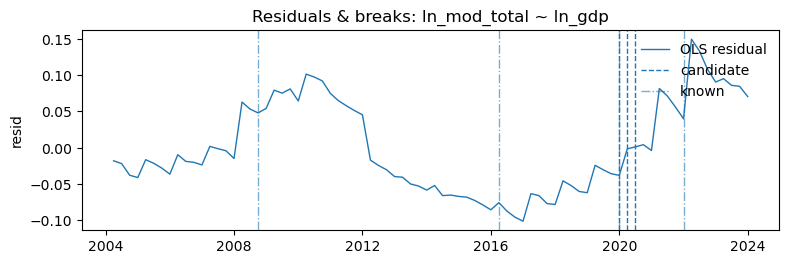

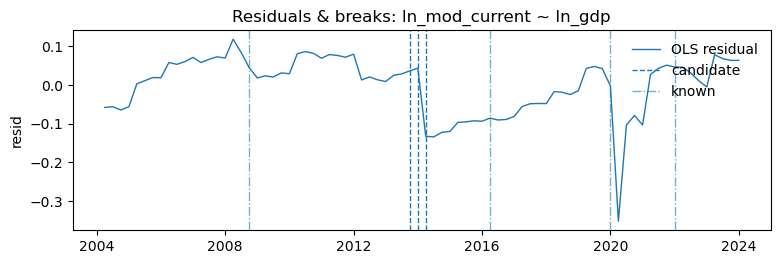

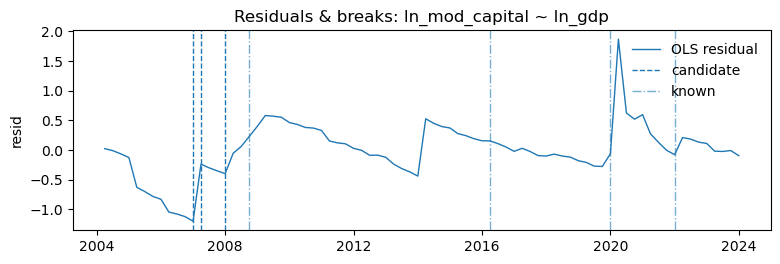

### Quick Unit-Root Summary

,variable,ADF_p,KPSS_p,integration
0,ln_gdp,NaN,NaN,Unavailable
1,ln_mod_total,NaN,NaN,Unavailable
2,ln_mod_current,NaN,NaN,Unavailable
3,ln_mod_capital,NaN,NaN,Unavailable


### Top break candidates (sup-F, per pair)

,break,F,p,pair
53,2020Q2,53.867059,2.664535e-15,ln_mod_total~ln_gdp
54,2020Q3,53.226508,3.552714e-15,ln_mod_total~ln_gdp
52,2020Q1,52.211355,5.440093e-15,ln_mod_total~ln_gdp
55,2020Q4,52.185080,5.440093e-15,ln_mod_total~ln_gdp
56,2021Q1,51.958244,5.995204e-15,ln_mod_total~ln_gdp
28,2014Q1,219.862285,1.110223e-16,ln_mod_current~ln_gdp
27,2013Q4,135.593237,1.110223e-16,ln_mod_current~ln_gdp
29,2014Q2,116.309280,1.110223e-16,ln_mod_current~ln_gdp
26,2013Q3,97.094654,1.110223e-16,ln_mod_current~ln_gdp
30,2014Q3,79.567852,1.110223e-16,ln_mod_current~ln_gdp



==== Saved files (project-relative) ====
[data] /data/processed/master_panel_phaseC_rebuild.csv
[data] /figures/tables/phaseC_unit_root_tests.csv
[data] /figures/tables/phaseC_unit_root_summary.csv
[data] /figures/tables/phaseC_chow_known.csv
[data] /figures/tables/phaseC_breakscan_top.csv
[figure] /figures/phaseC_breaks_ln_mod_total_vs_ln_gdp.png
[figure] /figures/phaseC_breaks_ln_mod_current_vs_ln_gdp.png
[figure] /figures/phaseC_breaks_ln_mod_capital_vs_ln_gdp.png
[data] /figures/tables/phaseC_data_dictionary.csv
[doc] /outputs/phaseC/phaseC_data_dictionary.md

Source files used:
  ABMI  -> /data/interim/abmi_q.csv
  YBGB  -> /data/interim/ybgb_q.csv
  YBHA  -> /data/interim/ybha_q.csv
  MoD nominal (wide) -> /data/interim/defence_q_nominal_wide.csv

[Phase C] Complete. Plots shown above; tables and figures saved to disk.


In [1]:
# ===== Phase C (reliable rebuild) — Unit roots, break screen, and inline plots =========
# Builds a clean Phase-C panel from INTERIM sources (ABMI, YBGB, MoD nominal),
# runs ADF+KPSS, Chow tests at known dates, an unknown-date sup-F scan,
# SAVES all outputs to standard folders, and SHOWS key plots inline.
# Prints a project-relative manifest like /figures/... and /figures/tables/...
# =================================================================================================

import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import f as fdist
from IPython.display import display, Markdown

# -------------------------- Paths & folders --------------------------
PROJECT_ROOT = Path.cwd().resolve()  # use current working directory as project root

FIGDIR = Path("figures"); FIGDIR.mkdir(parents=True, exist_ok=True)
TABDIR = FIGDIR / "tables"; TABDIR.mkdir(parents=True, exist_ok=True)
OUTDIR = Path("outputs") / "phaseC"; OUTDIR.mkdir(parents=True, exist_ok=True)
PROCDIR = Path("data") / "processed"; PROCDIR.mkdir(parents=True, exist_ok=True)

SAVED = []  # collect (kind, relative_path) for printing at the end

# -------------------------- Helpers --------------------------
def _rel(p: Path) -> str:
    """
    Return a clean project-relative POSIX path prefixed with '/',
    e.g. '/figures/tables/phaseC_unit_root_tests.csv'
    """
    p = Path(p)
    try:
        rp = p.resolve().relative_to(PROJECT_ROOT)
    except Exception:
        # fallback to relpath even if outside project
        try:
            rp = Path(os.path.relpath(p.resolve(), PROJECT_ROOT))
        except Exception:
            return "/" + p.as_posix().lstrip("/")  # best-effort
    return "/" + rp.as_posix().lstrip("/")

def _read_first(paths, **kw):
    """Read the first CSV that exists from a list of candidate paths."""
    for p in paths:
        pth = Path(p)
        if pth.exists():
            try:
                df = pd.read_csv(pth, **kw)
                return df, pth
            except Exception:
                # try alternate encoding
                df = pd.read_csv(pth, encoding="latin1", **kw)
                return df, pth
    raise FileNotFoundError(f"None of these files exist: {paths}")

def qidx(s):  # quarter index
    return pd.PeriodIndex(s, freq="Q")

def _find_one(df, candidates):
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        k = cand.lower()
        if k in cols: return cols[k]
    # loose contains match
    for cand in candidates:
        for c in df.columns:
            if cand.lower() in c.lower():
                return c
    return None

def _save(df_or_fig, path, kind="file"):
    """
    Save DF to CSV or Figure to PNG and register a project-relative path in SAVED.
    """
    path = Path(path)
    if hasattr(df_or_fig, "to_csv"):
        df_or_fig.to_csv(path, index=False)
    else:
        df_or_fig.savefig(path, dpi=200, bbox_inches="tight")
    SAVED.append((kind, _rel(path)))
    return path

# -------------------------- Load INTERIM sources --------------------------
abmi, abmi_path = _read_first([
    "data/interim/abmi_q.csv", "/mnt/data/abmi_q.csv"
])
ybgb, ybgb_path = _read_first([
    "data/interim/ybgb_q.csv", "data/interim/series-030725_tidy.csv", "/mnt/data/ybgb_q.csv"
])
ybha, ybha_path = _read_first([
    "data/interim/ybha_q.csv", "/mnt/data/ybha_q.csv"
])
defw, defw_path = _read_first([
    "data/interim/defence_q_nominal_wide.csv", "/mnt/data/defence_q_nominal_wide.csv"
])

# Quarter keys
abmi["q"] = qidx(abmi["quarter"])
ybgb["q"] = qidx(ybgb["quarter"])
ybha["q"] = qidx(ybha["quarter"])
defw["q"]  = qidx(defw["quarter"])

# Normalize common column names
defl_col = _find_one(ybgb, ["deflator_index","ybgb_index","gdp_deflator_index","value"])
if defl_col != "deflator_index":
    ybgb = ybgb.rename(columns={defl_col: "deflator_index"})

defw = defw.rename(columns={c: c.lower() for c in defw.columns})

# -------------------------- Assemble Phase-C panel --------------------------
panel = pd.DataFrame(index=sorted(defw["q"].unique()))
panel.index.name = "quarter"

# Real GDP: ensure ln exists; compute if needed
abmi_cols = {c.lower(): c for c in abmi.columns}
gdp_real_col = abmi_cols.get("gdp_real_mn")
ln_gdp_col   = abmi_cols.get("ln_gdp_real")
if ln_gdp_col is None and gdp_real_col is not None:
    abmi["ln_gdp_real"] = np.log(pd.to_numeric(abmi[gdp_real_col], errors="coerce").replace({0: np.nan}))
    ln_gdp_col = "ln_gdp_real"

panel = panel.join(abmi.set_index("q")[["gdp_real_mn", ln_gdp_col]].rename(columns={ln_gdp_col: "ln_gdp"}), how="left")
panel = panel.join(ybha.set_index("q")[["gdp_nom_mn"]], how="left")
panel = panel.join(ybgb.set_index("q")[["deflator_index"]], how="left")
panel = panel.join(defw.set_index("q")[["total","current","capital"]], how="left")

# If ln_gdp still missing but we do have gdp_real_mn, compute it
if panel["ln_gdp"].isna().all() and panel["gdp_real_mn"].notna().any():
    panel["ln_gdp"] = np.log(pd.to_numeric(panel["gdp_real_mn"], errors="coerce").replace({0: np.nan}))

# Deflate MoD nominal by YBGB (2019=100)
def _deflate(nom, defl):
    n = pd.to_numeric(nom, errors="coerce")
    d = pd.to_numeric(defl, errors="coerce")/100.0
    return n / d

panel["mod_total_real"]     = _deflate(panel["total"],   panel["deflator_index"])
panel["mod_current_real"]   = _deflate(panel["current"], panel["deflator_index"])
panel["mod_capital_real"]   = _deflate(panel["capital"], panel["deflator_index"])
panel["ln_mod_total"]       = np.log(panel["mod_total_real"].replace({0: np.nan}))
panel["ln_mod_current"]     = np.log(panel["mod_current_real"].replace({0: np.nan}))
panel["ln_mod_capital"]     = np.log(panel["mod_capital_real"].replace({0: np.nan}))

# Save the rebuilt master for reproducibility
rebuilt_path = _save(panel.reset_index(), PROCDIR / "master_panel_phaseC_rebuild.csv", kind="data")

# -------------------------- Unit-root tests (safe) --------------------------
def safe_adf(x, reg="c"):
    s = pd.to_numeric(x, errors="coerce").dropna()
    if s.nunique() <= 1 or len(s) < 10:
        return {"stat": np.nan, "p": np.nan, "lags": np.nan, "nobs": len(s), "cv_1%": np.nan, "cv_5%": np.nan, "cv_10%": np.nan, "error":"insufficient variation/sample"}
    try:
        stat,p,lag,nobs,crit,_ = adfuller(s, regression=reg, autolag="AIC")
        return {"stat":stat,"p":p,"lags":lag,"nobs":nobs,"cv_1%":crit["1%"],"cv_5%":crit["5%"],"cv_10%":crit["10%"],"error":None}
    except Exception as e:
        return {"stat": np.nan, "p": np.nan, "lags": np.nan, "nobs": len(s), "cv_1%": np.nan, "cv_5%": np.nan, "cv_10%": np.nan, "error": str(e)}

def safe_kpss(x, reg="c"):
    s = pd.to_numeric(x, errors="coerce").dropna()
    if s.nunique() <= 1 or len(s) < 10:
        return {"stat": np.nan, "p": np.nan, "lags": np.nan, "cv_10%": np.nan, "cv_5%": np.nan, "cv_2.5%": np.nan, "cv_1%": np.nan, "error":"insufficient variation/sample"}
    try:
        stat,p,lag,crit = kpss(s, regression=reg, nlags="auto")
        return {"stat":stat,"p":p,"lags":lag,"cv_10%":crit.get("10%",np.nan),"cv_5%":crit.get("5%",np.nan),"cv_2.5%":crit.get("2.5%",np.nan),"cv_1%":crit.get("1%",np.nan),"error":None}
    except Exception as e:
        return {"stat": np.nan, "p": np.nan, "lags": np.nan, "cv_10%": np.nan, "cv_5%": np.nan, "cv_2.5%": np.nan, "cv_1%": np.nan, "error": str(e)}

vars4 = ["ln_gdp","ln_mod_total","ln_mod_current","ln_mod_capital"]
rows=[]
for v in vars4:
    lvl = panel[v]
    d1  = lvl.diff()
    rows += [
        {"variable":v,"transform":"level","test":"ADF c", **safe_adf(lvl,"c")},
        {"variable":v,"transform":"level","test":"KPSS c", **safe_kpss(lvl,"c")},
        {"variable":v,"transform":"level","test":"ADF ct",**safe_adf(lvl,"ct")},
        {"variable":v,"transform":"level","test":"KPSS t", **safe_kpss(lvl,"ct")},
        {"variable":v,"transform":"diff1","test":"ADF c", **safe_adf(d1,"c")},
        {"variable":v,"transform":"diff1","test":"KPSS c", **safe_kpss(d1,"c")},
    ]
tests = pd.DataFrame(rows)
tests_path = _save(tests, TABDIR / "phaseC_unit_root_tests.csv", kind="data")

def _judge(adf_p, kpss_p, a=0.05):
    if pd.isna(adf_p) and pd.isna(kpss_p): return "Unavailable"
    if (not pd.isna(adf_p)) and adf_p < a and (pd.isna(kpss_p) or kpss_p >= a): return "I(0)"
    if (pd.isna(adf_p) or adf_p >= a) and (not pd.isna(kpss_p)) and kpss_p < a: return "I(1)"
    return "Ambiguous"

def _get_p(df, var, trans, test):
    sub = df[(df.variable==var)&(df.transform==trans)&(df.test==test)]
    return sub["p"].iloc[0] if len(sub) else np.nan

summary=[]
for v in vars4:
    a = _get_p(tests, v, "level", "ADF c")
    k = _get_p(tests, v, "level", "KPSS c")
    summary.append({"variable":v,"ADF_p":a,"KPSS_p":k,"integration":_judge(a,k)})
summary_df = pd.DataFrame(summary)
summary_path = _save(summary_df, TABDIR / "phaseC_unit_root_summary.csv", kind="data")

# -------------------------- Break tests: Chow (known) & sup-F (unknown) --------------------------
def _chow_known(y, x, idx, break_q, min_seg=12):
    d = pd.DataFrame({"y":y, "x":x}, index=idx).dropna()
    if d.empty: return {"break":break_q,"F":np.nan,"p":np.nan,"n1":np.nan,"n2":np.nan,"note":"no data"}
    bp = pd.Period(break_q, freq="Q")
    if bp not in d.index:
        before = d.index[d.index<=bp]
        if len(before)==0: return {"break":break_q,"F":np.nan,"p":np.nan,"n1":np.nan,"n2":np.nan,"note":"break not in sample"}
        bp = before.max()
    k = d.index.get_loc(bp)
    n = len(d); p = 2
    if k < min_seg or (n-k) < min_seg:
        return {"break":str(bp),"F":np.nan,"p":np.nan,"n1":k,"n2":n-k,"note":"short segment"}
    Xall = sm.add_constant(d["x"].values)
    SSRr = np.sum(sm.OLS(d["y"].values, Xall).fit().resid**2)
    y1,X1 = d["y"].values[:k], sm.add_constant(d["x"].values[:k])
    y2,X2 = d["y"].values[k:],  sm.add_constant(d["x"].values[k:])
    SSR1 = np.sum(sm.OLS(y1,X1).fit().resid**2)
    SSR2 = np.sum(sm.OLS(y2,X2).fit().resid**2)
    F = ((SSRr-(SSR1+SSR2))/p)/(((SSR1+SSR2))/(n-2*p))
    pval = 1 - fdist.cdf(F, p, n-2*p)
    return {"break":str(bp),"F":float(F),"p":float(pval),"n1":k,"n2":n-k,"note":None}

def _supF_scan(y, x, idx, min_seg=12):
    d = pd.DataFrame({"y":y, "x":x}, index=idx).dropna()
    if len(d) < 2*min_seg+1: 
        return pd.DataFrame(columns=["break","F","p"])
    Xall = sm.add_constant(d["x"].values)
    SSRr = np.sum(sm.OLS(d["y"].values, Xall).fit().resid**2)
    n = len(d); p = 2
    out=[]
    for k in range(min_seg, n-min_seg+1):
        y1,X1 = d["y"].values[:k], sm.add_constant(d["x"].values[:k])
        y2,X2 = d["y"].values[k:],  sm.add_constant(d["x"].values[k:])
        SSR1 = np.sum(sm.OLS(y1,X1).fit().resid**2)
        SSR2 = np.sum(sm.OLS(y2,X2).fit().resid**2)
        F = ((SSRr-(SSR1+SSR2))/p)/(((SSR1+SSR2))/(n-2*p))
        pval = 1 - fdist.cdf(F, p, n-2*p)
        out.append({"break":str(d.index[k-1]),"F":float(F),"p":float(pval)})
    return pd.DataFrame(out).sort_values("F", ascending=False)

pairs = [("ln_mod_total","ln_gdp"), ("ln_mod_current","ln_gdp"), ("ln_mod_capital","ln_gdp")]
KNOWN = ["2008Q4","2016Q2","2020Q1","2022Q1"]

# Known-date Chow table
rows=[]
for dep, indep in pairs:
    y = panel[dep]; x = panel[indep]; idx = panel.index
    for b in KNOWN:
        res = _chow_known(y, x, idx, b, min_seg=12)
        res.update({"pair":f"{dep}~{indep}"})
        rows.append(res)
chow_df = pd.DataFrame(rows)
chow_path = _save(chow_df, TABDIR / "phaseC_chow_known.csv", kind="data")

# Unknown-date sup-F maxima (top 5 per pair)
tops=[]
for dep, indep in pairs:
    y = panel[dep]; x = panel[indep]; idx = panel.index
    topk = _supF_scan(y, x, idx, min_seg=12).head(5)
    topk["pair"] = f"{dep}~{indep}"
    tops.append(topk)
breakscan_df = pd.concat(tops) if tops else pd.DataFrame(columns=["break","F","p","pair"])
breakscan_path = _save(breakscan_df, TABDIR / "phaseC_breakscan_top.csv", kind="data")

# -------------------------- Plot residuals (SAVE + SHOW inline) --------------------------
plot_paths = []
for dep, indep in pairs:
    df_xy = pd.DataFrame({"y":panel[dep], "x":panel[indep]}).dropna()
    if df_xy.empty: 
        continue
    m = sm.OLS(df_xy["y"].values, sm.add_constant(df_xy["x"].values)).fit()
    resid = pd.Series(m.resid, index=df_xy.index.to_timestamp())

    # get top breaks for this pair
    top_local = breakscan_df[breakscan_df["pair"]==f"{dep}~{indep}"].head(3)

    fig, ax = plt.subplots(figsize=(9, 2.6))
    ax.plot(resid.index, resid.values, lw=1, label="OLS residual")
    for _, r in top_local.iterrows():
        ax.axvline(pd.Period(r["break"], freq="Q").to_timestamp(), ls="--", lw=1, label="candidate" if _ == top_local.index[0] else None)
    for b in KNOWN:
        if b in df_xy.index.astype(str).values:
            ax.axvline(pd.Period(b, freq="Q").to_timestamp(), ls="-.", lw=1, alpha=0.6, label="known" if b==KNOWN[0] else None)
    ax.set_title(f"Residuals & breaks: {dep} ~ {indep}")
    ax.set_xlabel(""); ax.set_ylabel("resid"); ax.grid(False)
    ax.legend(loc="upper right", frameon=False)
    fpath = FIGDIR / f"phaseC_breaks_{dep}_vs_{indep}.png"
    _save(fig, fpath, kind="figure")
    plot_paths.append(fpath)
    plt.show()     # ---- SHOW the plot inline
    plt.close(fig)

# -------------------------- Data dictionary (SAVE + SHOW) --------------------------
dic = []
attrs = {
 "ln_gdp":         ("ABMI (CVM)", "log of £m", "Real (2019=100)", "ONS (ABMI)"),
 "ln_mod_total":   ("MoD nominal, deflated by YBGB", "log of £m", "Deflated by GDP deflator (2019=100)", "MoD + ONS (YBGB)"),
 "ln_mod_current": ("MoD nominal, deflated by YBGB", "log of £m", "Deflated by GDP deflator (2019=100)", "MoD + ONS (YBGB)"),
 "ln_mod_capital": ("MoD nominal, deflated by YBGB", "log of £m", "Deflated by GDP deflator (2019=100)", "MoD + ONS (YBGB)"),
}
for v,(code,units,price,src) in attrs.items():
    last = panel[v].dropna().index.max()
    dic.append({"standard_name":v,"series_code":code,"units":units,"price_basis":price,"last_obs":str(last),"source":src})
ddf = pd.DataFrame(dic)
dict_csv_path = _save(ddf, TABDIR / "phaseC_data_dictionary.csv", kind="data")

md_lines = ["# Phase C — Data Dictionary (Long-run level variables)",
            "",
            "| Name | Series Code | Units | Price basis | Last obs | Source |",
            "|---|---|---|---|---|---|"]
for r in dic:
    md_lines.append(f"| {r['standard_name']} | {r['series_code']} | {r['units']} | {r['price_basis']} | {r['last_obs']} | {r['source']} |")
dict_md_path = OUTDIR / "phaseC_data_dictionary.md"
with open(dict_md_path, "w", encoding="utf-8") as f:
    f.write("\n".join(md_lines))
SAVED.append(("doc", _rel(dict_md_path)))

# -------------------------- Show quick results inline --------------------------
display(Markdown("### Quick Unit-Root Summary"))
display(summary_df)

display(Markdown("### Top break candidates (sup-F, per pair)"))
display(breakscan_df)

# -------------------------- Final: project-relative manifest ------------------
print("\n==== Saved files (project-relative) ====")
for kind, rel in SAVED:
    print(f"[{kind}] {rel}")
print("========================================\n")

# Also show where we read the sources from (project-relative):
print("Source files used:")
print(f"  ABMI  -> {_rel(abmi_path)}")
print(f"  YBGB  -> {_rel(ybgb_path)}")
print(f"  YBHA  -> {_rel(ybha_path)}")
print(f"  MoD nominal (wide) -> {_rel(defw_path)}")

print("\n[Phase C] Complete. Plots shown above; tables and figures saved to disk.")

In [2]:
# Regenerate the CORRECTED Phase C unit-root summary (project-relative paths)
# - Reads:  /figures/tables/phaseC_unit_root_tests.csv
# - Writes: /figures/tables/phaseC_unit_root_summary.csv
# - Shows the summary inline and prints a clean project-relative path.

import pandas as pd, numpy as np, os
from pathlib import Path
from IPython.display import display, Markdown

# ----- helpers -----
PROJECT_ROOT = Path.cwd().resolve()
def _rel(p: Path) -> str:
    try:
        return "/" + p.resolve().relative_to(PROJECT_ROOT).as_posix()
    except Exception:
        return "/" + p.as_posix().lstrip("/")

# ----- locate the detailed tests file -----
candidates = [
    Path("figures/tables/phaseC_unit_root_tests.csv"),
    Path("phaseC_unit_root_tests.csv"),
    Path("figures/phaseC_unit_root_tests.csv"),
]
tests_path = next((p for p in candidates if p.exists()), None)
if tests_path is None:
    raise FileNotFoundError(
        "Couldn't find 'phaseC_unit_root_tests.csv'. "
        "Expected at /figures/tables/ or notebook folder."
    )

tests = pd.read_csv(tests_path)

# Ensure numeric p-values
tests["p"] = pd.to_numeric(tests["p"], errors="coerce")

# ----- judgement functions (same logic as earlier, but robust) -----
def judge(adf_p, kpss_p, a=0.05):
    if (pd.isna(adf_p)) and (pd.isna(kpss_p)):
        return "Unavailable"
    if (not pd.isna(adf_p)) and adf_p < a and (pd.isna(kpss_p) or kpss_p >= a):
        return "I(0)"
    if (pd.isna(adf_p) or adf_p >= a) and (not pd.isna(kpss_p)) and kpss_p < a:
        return "I(1)"
    return "Ambiguous"

def get_p(df, var, trans, test):
    # IMPORTANT: use bracket column access (not df.transform which is a method)
    sub = df[(df['variable']==var) & (df['transform']==trans) & (df['test']==test)]
    return sub['p'].iloc[0] if len(sub) else np.nan

# ----- build the summary -----
preferred_order = ["ln_gdp","ln_mod_total","ln_mod_current","ln_mod_capital"]
vars_present = [v for v in preferred_order if v in tests['variable'].unique()]

rows = []
for v in vars_present:
    a = get_p(tests, v, "level", "ADF c")
    k = get_p(tests, v, "level", "KPSS c")
    rows.append({"variable": v, "ADF_p": a, "KPSS_p": k, "integration": judge(a, k)})

summary = pd.DataFrame(rows)

# ----- save to the standard location -----
outdir = Path("figures/tables"); outdir.mkdir(parents=True, exist_ok=True)
out_path = outdir / "phaseC_unit_root_summary.csv"
summary.to_csv(out_path, index=False)

# ----- show + manifest -----
display(Markdown("### Phase C — Unit-Root Summary (corrected)"))
display(summary.style.format({"ADF_p": "{:.6f}", "KPSS_p": "{:.6f}"}))

print("\nSaved summary to:", _rel(out_path))
print("Read tests from:", _rel(tests_path))

### Phase C — Unit-Root Summary (corrected)

,variable,ADF_p,KPSS_p,integration
0,ln_gdp,0.597866,0.010000,I(1)
1,ln_mod_total,0.466597,0.100000,Ambiguous
2,ln_mod_current,0.760426,0.010000,I(1)
3,ln_mod_capital,0.740087,0.010000,I(1)



Saved summary to: /figures/tables/phaseC_unit_root_summary.csv
Read tests from: /figures/tables/phaseC_unit_root_tests.csv
